In [1]:
import keras
from keras import Input, layers, optimizers, Model
from keras.applications import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential, Model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.layers.merge import add
from keras.utils import to_categorical
import numpy as np
import glob
import pandas as pd
from numpy import array
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load InceptionV3 model and remove the softmax layer
inceptionV3_model = InceptionV3(weights='imagenet')
model = Model(inceptionV3_model.input, inceptionV3_model.layers[-2].output)

In [3]:
# Load the train and test data
data_path = "Data/CaptionPredictionData/"
train_data = pd.read_csv(data_path + "Descriptions_all_train.csv", sep=";")
test_data = pd.read_csv(data_path + "Descriptions_all_test.csv", sep=";")
train_image_names = train_data.iloc[:,0]
test_image_names = test_data.iloc[:,0]
train_images = glob.glob(data_path + 'Data/train/all/*')
test_images = glob.glob(data_path + 'Data/test/all/*')

In [4]:
# Function to prepare the images to be feed into the inception v3 model
def prepare_image(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    preprocessed_image = preprocess_input(array)
    return preprocessed_image

# Function to encode a given image into a vector
def encode(image, model):
    preprocessed_image = prepare_image(image)
    encoded_vector = model.predict(preprocessed_image)
    encoded_vector = np.reshape(encoded_vector, encoded_vector.shape[1])
    return encoded_vector

In [5]:
def encode_images(images): 
    encoded_images = {}
    for img in images:
        encoded_images[img.split("\\")[1]] = encode(img, model)
    return encoded_images

# Save the encoded images as pickle files to speed up future executions
with open("CaptionPrediction/Pickle/encoded_train_images.pkl", "wb") as encoded_train_pickle:
    pickle.dump(encode_images(train_images), encoded_train_pickle)
    
with open("CaptionPrediction/Pickle/encoded_test_images.pkl", "wb") as encoded_test_pickle:
    pickle.dump(encode_images(test_images), encoded_test_pickle)

C:\Users\Xavi\Anaconda3\envs\TFM\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [6]:
train_features = pickle.load(open("CaptionPrediction/Pickle/encoded_train_images.pkl", "rb"))

In [7]:
# Load the descriptions and add start and end tokens
def load_clean_descriptions(train_data):
    descriptions = {}
    for index,row in train_data.iterrows():
        desc = '#START ' + row[1] + ' #END'
        descriptions[row[0]] = []
        descriptions[row[0]].append(desc)
    return descriptions

train_descriptions = load_clean_descriptions(train_data)
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [8]:
def generate_corpus(threshold, descriptions):
    words = {}
    for description in descriptions:
        for word in description.split(' '):
            words[word] = words.get(word, 0) + 1
    
    return  [word for word in words if words[word] >= threshold]


corpus_vocab = generate_corpus(2, all_train_captions)

In [9]:
word_to_position = {}
position_to_word = {}
position = 1
for word in corpus_vocab:
    word_to_position[word] = position
    position_to_word[position] = word
    position += 1
vocab_size = len(position_to_word) + 1
vocab_size

99

In [10]:
# Get maximum sequence length
max_length = max(len(description.split()) for description in all_train_captions)
max_length

19

In [22]:
with open('Model/corpus_all.txt', 'wb') as corpus_file:
    pickle.dump(corpus_vocab, corpus_file)

In [11]:
def data_generator(descriptions, images, word_to_position, max_length, batch_images):
    X1, X2, y = [], [], []
    counter=0
    # loop for ever over images
    while True:
        for key, desc_list in descriptions.items():
            counter+=1
            image = images[key]
            for description in desc_list:
                # encode the sequence
                seq = [word_to_position[word] for word in description.split(' ') if word in word_to_position]
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(image)
                    X2.append(in_seq)
                    y.append(out_seq)
            if counter==batch_images:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = [], [], []
                counter=0

In [12]:
# Load Glove vectors
glove_dir = data_path + 'glove'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_position.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
# Image Input and layers to avoid overfitting
input_1 = Input(shape=(2048,))
image_layer_1 = Dropout(0.5)(input_1)
image_layer_2 = Dense(256, activation='relu')(image_layer_1)

# Partial caption input and LSTM layer
input_2 = Input(shape=(max_length,))
caption_layer_1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_2)
caption_layer_2 = Dropout(0.5)(caption_layer_1)
caption_layer_3 = LSTM(256)(caption_layer_2)

# Merge the two inputs and decode
decoder_1 = add([image_layer_2, caption_layer_3])
decoder_2 = Dense(256, activation='relu')(decoder_1)

# Output
outputs = Dense(vocab_size, activation='softmax')(decoder_2)

model = Model(inputs=[input_1, input_2], outputs=outputs)

model.summary()

# Add the weights from the Glove model and make it not trainable
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 19)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 19, 200)      19800       input_3[0][0]                    
__________________________________________________________________________________________________

In [14]:
epochs = 50
batch_images = 2
steps = len(train_descriptions)//batch_images

generator = data_generator(train_descriptions, train_features, word_to_position, max_length, batch_images)
model.fit_generator(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)
model.save('Model/caption_pred_model_all.h5')



Epoch 1/50
249/249 [==============================] - 31s 125ms/step - loss: 2.0327
Epoch 2/50
249/249 [==============================] - 21s 85ms/step - loss: 1.2384
Epoch 3/50
249/249 [==============================] - 19s 75ms/step - loss: 1.0314
Epoch 4/50
249/249 [==============================] - 19s 74ms/step - loss: 0.8840
Epoch 5/50
249/249 [==============================] - 19s 77ms/step - loss: 0.8188
Epoch 6/50
249/249 [==============================] - 19s 77ms/step - loss: 0.7206
Epoch 7/50
249/249 [==============================] - 19s 75ms/step - loss: 0.7125
Epoch 8/50
249/249 [==============================] - 19s 76ms/step - loss: 0.6869
Epoch 9/50
249/249 [==============================] - 26s 103ms/step - loss: 0.6452
Epoch 10/50
249/249 [==============================] - 27s 107ms/step - loss: 0.6186
Epoch 11/50
249/249 [==============================] - 23s 92ms/step - loss: 0.5892
Epoch 12/50
249/249 [==============================] - 21s 85ms/step - loss: 0.5

In [17]:
model_yaml = model.to_yaml()
with open("Model/caption_pred_model_all.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [15]:
# Load the model with test data
model.load_weights('Model/caption_pred_model_all.h5')

with open("CaptionPrediction/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

def greedy_search(photo):
    in_text = '#START'
    for i in range(max_length):
        sequence = [word_to_position[w] for w in in_text.split() if w in word_to_position]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = position_to_word[yhat]
        in_text += ' ' + word
        if word == '#END':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

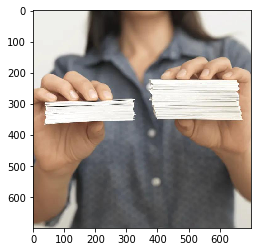

A squared corner business card being held by a hand


In [16]:
# Test the model
path="Data/CaptionPredictionData/Data/test/all/"
index=165
pic = list(encoding_test.keys())[index]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(path+pic)
plt.imshow(x)
plt.show()
print(greedy_search(image))